In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY
import matplotlib.gridspec as gridspec

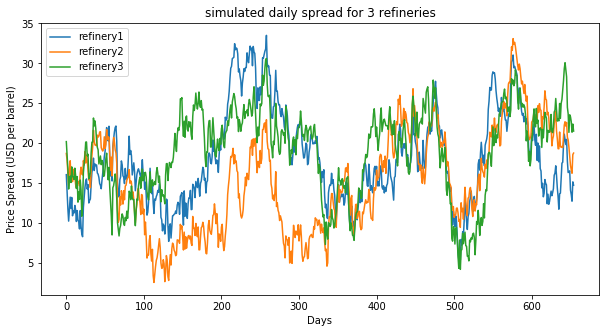

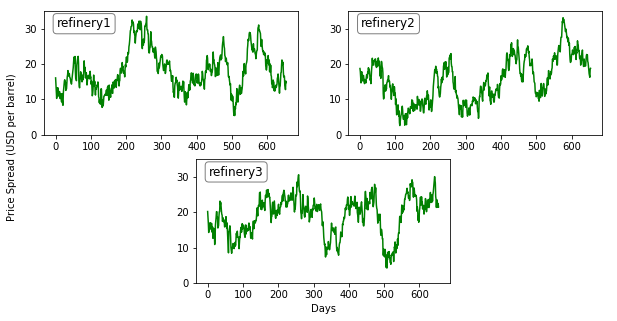

In [2]:
"""using the coefficients form the calibration of the spread of WTI/WCS
simulate 3 price spreads sequence with made-up correlation matrix COR.
"""
# Plot Parameters
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['lines.linewidth'] = 1.5


dataframe = pd.read_csv('Data/generateOUpath.csv')
spread1 = dataframe['path1']
spread2 = dataframe['path2']
spread3 = dataframe['path3']

#T=200
spread = [spread1, spread2, spread3]
N = len(spread)
T = len(spread1)

spread = [[round(spread[i][j],2) for j in range(T)] for i in range(N)]
# print(spread)
# 5 is pretty much the spread of heavy and light crude oil at same place
# then the spread now is combination of the transportation cost (pipeline) and the congestion surcharge
fig, ax = plt.subplots()

plt.plot(spread1[:T], label='refinery1')
plt.plot(spread2[:T], label='refinery2')
plt.plot(spread3[:T], label='refinery3')
plt.title('simulated daily spread for 3 refineries')
plt.xlabel('Days')
plt.ylabel('Price Spread (USD per barrel)')
plt.legend()
plt.show()


fig = plt.figure()

ax.set_xlabel('common xlabel')
ax.set_ylabel('common ylabel')

gs = gridspec.GridSpec(2,2)

ax = fig.add_subplot(111)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])
ax3=fig.add_subplot(gs[1,:])

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(spread1[:T], label='refinery1', c='g')
ax2.plot(spread2[:T], label='refinery2', c='g')
ax3.plot(spread3[:T], label='refinery3', c='g')
ax3.set_aspect(10)

# Set common labels
ax.set_xlabel('Days')
ax.set_ylabel('Price Spread (USD per barrel)')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.05, 0.95, 'refinery1', transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax1.set_ylim(0, 35)
ax2.text(0.05, 0.95, 'refinery2', transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax2.set_ylim(0, 35)
ax3.text(0.05, 0.95, 'refinery3', transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
ax3.set_ylim(0, 35)

plt.savefig("Figures/Separate_Refineries", dpi=200)
# plt.show()


In [3]:
nodes = ['refinery1', 'refinery2','refinery3']
#trans_cost = [6.35]
# transportation cost from Hardisty to Cushing is 5.65-7.05 by Enbridge and 6.35 to 10.46 by Keystone
# choose the midpoint of Enbridge
beta = .4   # percentage of the time with congestion
M = 100   # a reasonable upperbound for congestion surcharge

print(T)

model = Model()

'''model.cut_passes = 30
model.infeas_tol = 0.01
model.integer_tol = 0.001'''


# define the variables for 3 locations
eps = [[model.add_var(lb=-20, ub=20) for t in range(T)] for i in range(N)]
omega = [[model.add_var(lb=0, ub=50) for t in range(T)] for i in range(N)]
alpha = [model.add_var(lb=0, ub=20) for i in range(N)]
psi = [model.add_var(var_type=BINARY) for t in range(T)]
gamma = [[model.add_var(var_type=BINARY) for t in range(T)] for i in range(N)]
trans_cost = [model.add_var(lb=4) for i in range(N)]
# objective function
model.objective = minimize(xsum(alpha[i] for i in range(N)))





655


In [ ]:
#constrains
for i in range(N):
    for t in set(range(T)):
        model += spread[i][t] - trans_cost[i] - eps[i][t] - omega[i][t] == 0, 'price decompose'
        model += eps[i][t] + alpha[i] >= 0, 'boundary for eps is [-alpha, alpha]'
        model += eps[i][t] - alpha[i] <= 0
        model += eps[i][t] - alpha[i] + (1 - gamma[i][t]) * M >= 0, ''
        model += omega[i][t] - gamma[i][t] * M <= 0

for t in set(range(T)):
    model += xsum(gamma[i][t] for i in range(N)) >= psi[t]
    model += xsum(gamma[i][t] for i in range(N)) <= N*psi[t]

model += xsum(psi[t] for t in range(T)) <= int(beta*T)

# optimizing
model.optimize()

In [ ]:
if model.num_solutions:
#     print('optimal solution cost {} found'.format(model.objective_value))
    #print('optimal trans. cost {} found'.format(trans_cost.x))

    omega1 = [[omega[i][t].x for t in range(T)] for i in range(N)] # congestion surcharge
    neutral_bound = [alpha[i].x for i in range(N)]
    transCost = [trans_cost[i].x for i in range(N)]
#     print('congestion surcharge (omega) found: %s' % omega1)
#     print('neutral bound (epsilon) found: %s' % neutral_bound)
#     print('transportation cost (rho) found: %s' % transCost)

#     plt.plot(spread[0], label='spread-refinery 1')
#     plt.plot(omega1[0], label = 'Congestion surcharge-refinery 1')
#     plt.legend()
#     plt.show()

#     plt.plot(spread[1], label='spread-refinery 2')
#     plt.plot(omega1[1], label='Congestion surcharge-refinery 2')
#     plt.legend()
#     plt.show()

#     plt.plot(spread[2], label='spread-refinery 3')
#     plt.plot(omega1[2], label='Congestion surcharge-refinery 3')
#     plt.legend()
#     plt.show()

    plt.plot(omega1[0],label='Congestion surcharge-refinery 1')
    plt.plot(omega1[1], label='Congestion surcharge-refinery 2')
    plt.plot(omega1[2], label='Congestion surcharge-refinery 3')
    plt.ylim(0,35)
    #plt.title('congestion surcharge for 3 pseudo refineries for beta = %s' % beta)
    plt.xlabel('Days')
    plt.ylabel('USD per barrel')
    plt.legend()
    plt.show()